### RGCN 
In this notebook we want to make an easy implementation of the RGCN model from scratch - namely using only Pytorch (no pyg or dgl or whatever)

The first task will probably be defining a class to define a RGCN layer. 

In order to do that we will have to remember what we need!

- 

In [1]:
#import libraries

import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import kgbench as kg
import fire, sys

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


#
from torch_geometric.utils import to_networkx
import networkx as nx


/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = kg.load('aifb', torch=True) 
print(f'Number of entities: {data.num_entities}') #data.i2e
print(f'Number of classes: {data.num_classes}')
print(f'Types of relations: {data.num_relations}') #data.i2r
data.triples


loaded data aifb (0.3412s).
Number of entities: 8285
Number of classes: 4
Types of relations: 45


tensor([[4938,   39, 8181],
        [4938,   42, 8175],
        [4938,   44, 5292],
        ...,
        [7628,   37,  350],
        [7628,   39, 5220],
        [8052,   39, 8178]])

In [6]:
#one adjacency 
def edge_index_oneadj(data):
    edge_index = torch.stack((data.triples[:, 0], data.triples[:, 2]),dim=0)
    return edge_index


def edge_index_reladj(data):
    data.edge_index = torch.stack((data.triples[:, 0], data.triples[:, 2]), dim=0)
    data.edge_type = data.triples[:, 1]
    return data.edge_index, data.edge_type


def edge_index_dic(data):# Create an empty dictionary
    data.edge_index = {}

    # Iterate over some keys and values and append the values to the dictionary
    for i in np.unique(data.triples[:,1]):
        # Create some key and value (e.g. index and data)
        key = i
        value = [(s.item(), o.item()) for s, p, o in data.triples[torch.eq(data.triples[:, 1], i)]]
        value = torch.Tensor(value).t().long()
        #value = torch.Tensor(value).long()
        # Check if the key is already in the dictionary
        if key in data.edge_index:
            # If the key is already in the dictionary, append the value to the existing list
            data.edge_index[key].append(value)
        else:
            # If the key is not yet in the dictionary, create a new list with the value
            data.edge_index[key] = value
    return data.edge_index   

def get_adjacency(data):
    data.edge_index = edge_index_oneadj(data)
    adj = torch.zeros(data.num_entities, data.num_entities)
    for edge in data.edge_index.t():
        adj[edge[0]][edge[1]] = 1
        adj[edge[1]][edge[0]] = 1

    return adj



def get_adjacencies_dict(data):
    data.edge_index = edge_index_dic(data)
    adj = torch.zeros(data.num_entities, data.num_entities)
    for i in np.unique(data.triples[:,1]):
        for edge in data.edge_index[i].t():
            adj[edge[0]][edge[1]] = i+1
            adj[edge[1]][edge[0]] = i+1

    
    return adj

In [19]:
# get_adjacencies_dict(data)
# get_adjacency(data)

## Nieghborhood
We define functions to extract neighborhood for the sake of visualization of node connectivity (and because it will be somehow useful then)

In [14]:
def neighborhoods(adj, n_hops):
    """Returns the n_hops degree adjacency matrix adj."""
    adj = torch.tensor(adj, dtype=torch.float)
    hop_adj = power_adj = adj
    for i in range(n_hops - 1):
        power_adj = power_adj @ adj
        prev_hop_adj = hop_adj
        hop_adj = hop_adj + power_adj
        #print(type(hop_adj))
        hop_adj = (hop_adj > 0).float()
        #print(hop_adj)
    return hop_adj.cpu().numpy().astype(int)

def extract_neighborhood(node_idx,adj,n_hops):
    """Returns the neighborhood of a given ndoe."""
    neighbors_adj_row = neighborhoods(adj,n_hops)[node_idx, :] #take row of the node in the new adj matrix
    # index of the query node in the new adj
    node_idx_new = sum(neighbors_adj_row[:node_idx]) #sum of all the nodes before the query node (since they are 1 or 0) - it becomes count of nodes before the query node
    neighbors = np.nonzero(neighbors_adj_row)[0] #return the indices of the nodes that are connected to the query node (and thus are non zero)
    sub_adj = adj[neighbors][:, neighbors]
    return node_idx_new, neighbors , sub_adj

#node_idx_new, neighbors, sub_adj = extract_neighborhood(5757,get_adjacency(data),1)
node_idx_new, neighbors, sub_adj = extract_neighborhood(5757,get_adjacencies_dict(data),1)

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_16387/4292683132.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)


In [18]:
get_adjacencies_dict(data)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

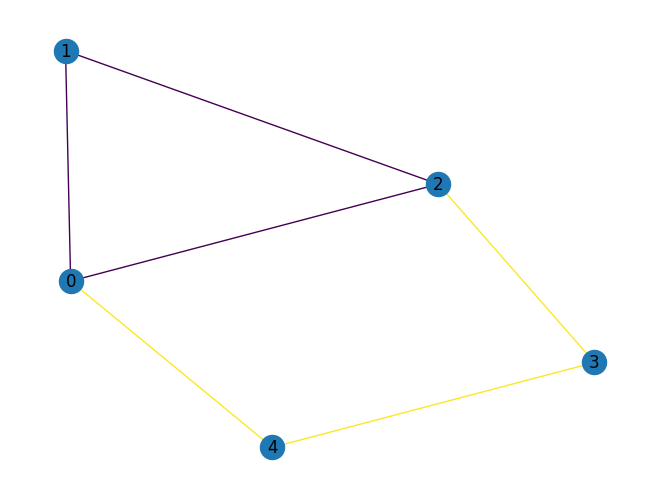

In [8]:
#MICRO DATASET
adj_dict = get_adjacencies_dict(data)
#adj_dict = sub_adj

G = nx.from_pandas_adjacency(pd.DataFrame(adj_dict.detach().numpy()))

colors = [adj_dict.detach().numpy()[u][v] for u, v in G.edges()]

nx.draw(G, with_labels=True, edge_color=colors)

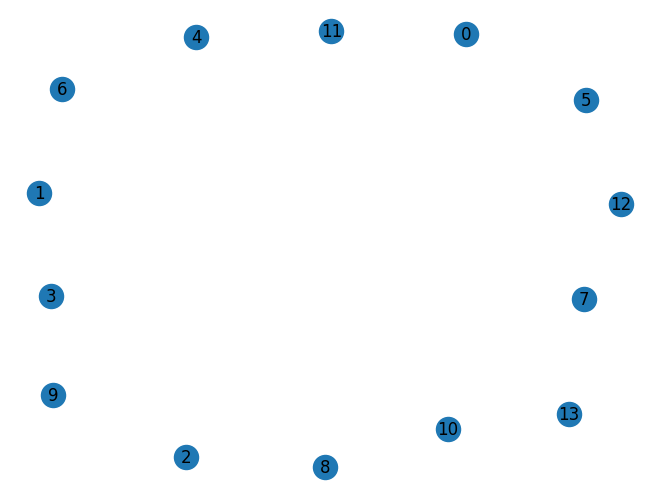

In [15]:
#AIFB
adj_dict = sub_adj

G = nx.from_pandas_adjacency(pd.DataFrame(adj_dict.detach().numpy()))

colors = [adj_dict.detach().numpy()[u][v] for u, v in G.edges()]

nx.draw(G, with_labels=True, edge_color=colors)

In [17]:
adj_dict

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Data preparation
- add self-loops and inverse relation to the KG
- adjacency matrix for each relation type



In [3]:
def enrich(triples : torch.Tensor, n : int, r: int):
    """
    Enriches the given triples with self-loops and inverse relations.

    """
    cuda = triples.is_cuda

    inverses = torch.cat([
        triples[:, 2:],
        triples[:, 1:2] + r,
        triples[:, :1]
    ], dim=1)

    selfloops = torch.cat([
        torch.arange(n, dtype=torch.long,  device=d(cuda))[:, None],
        torch.full((n, 1), fill_value=2*r),
        torch.arange(n, dtype=torch.long, device=d(cuda))[:, None],
    ], dim=1)

    return torch.cat([triples, inverses, selfloops], dim=0)

a = enrich(data.triples, data.num_entities, data.num_relations)
len(a)

66371

## ADJ
The whole idea of creating the adjacency matrix for multiple relation in here is based on the idea of having an adjacency matrix with size :(num_nodes * num_nodes,num_nodes * num_nodes)  where in each portion of the adjacency matrix a different relation is defined.

So for instance in the first 'quadrant' nxn we have the relations of relation type 1, in the second 'quadrant' relation type 2 and so on - where to move between quadrants we 'jump' of num_nodes rows and columns.

In [11]:
#here we print the adjacency matrix with original triples and where the different relation types are not taken into account
#original adjacency - no enriched triples
n = data.num_entities
adj_matrix = np.zeros((n, n), dtype=int)

# Fill the adjacency matrix with the edges
for edge in edge_index_oneadj(data).t():
#for edge in hor_ind:
    adj_matrix[edge[0]][edge[1]] = 1
    #adj_matrix[edge[1]][edge[0]] = 1

print(adj_matrix)

[[0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [1 0 0 1 0]]


In [25]:
def adj(triples, num_nodes, num_rels, cuda=False, vertical=True):
    """
     Computes a sparse adjacency matrix for the given graph (the adjacency matrices of all
     relations are stacked vertically).

     :param edges: List representing the triples
     :param i2r: list of relations
     :param i2n: list of nodes
     :return: sparse tensor
    """
    r, n = num_rels, num_nodes
    size = (r * n, n) if vertical else (n, r * n)

    from_indices = []
    upto_indices = []

    for s, p, o in triples:

        offset = p.item() * n
        print(offset)

        if vertical:
            s = offset + s.item()
        else:
            o = offset + o.item()

        from_indices.append(s)
        upto_indices.append(o)
        

    indices = torch.tensor([from_indices, upto_indices], dtype=torch.long, device=d(cuda))


    assert indices.size(1) == len(triples)
    assert indices[0, :].max() < size[0], f'{indices[0, :].max()}, {size}, {r}'
    assert indices[1, :].max() < size[1], f'{indices[1, :].max()}, {size}, {r}'

    return indices.t(), size
triples = enrich(data.triples,data.num_entities, data.num_relations)
indices, size = adj(triples, data.num_entities, triples.shape[0], cuda=False, vertical=False)

#indices, size = adj(data.triples, data.num_entities, data.num_relations, cuda=False, vertical=True)
# print(indices)
# print(data.triples)

def get_adjacency(indices):
    #data.edge_index = edge_index_oneadj(data)
    adj = torch.zeros(size[0]*4, size[0]*4)
    for edge in indices.t():
        print(edge)
        adj[edge[0]][edge[1]] = 1
        adj[edge[1]][edge[0]] = 1
        #adj[edge[0]][edge[0]] = 1

    return adj

adj_matrix = get_adjacency(indices)
print(adj_matrix)
size

0
0
0
5
5
5
10
10
10
15
15
15
20
20
20
20
20
tensor([0, 1, 0, 2, 4, 4, 1, 2, 2, 3, 3, 0, 0, 1, 2, 3, 4])
tensor([ 1,  2,  2,  8,  8,  5, 10, 11, 10, 17, 19, 19, 20, 21, 22, 23, 24])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0

(5, 85)

In [11]:
def neighborhoods(adj, n_hops):
    """Returns the n_hops degree adjacency matrix adj."""
    adj = torch.tensor(adj, dtype=torch.float)
    hop_adj = power_adj = adj
    for i in range(n_hops - 1):
        power_adj = power_adj @ adj
        prev_hop_adj = hop_adj
        hop_adj = hop_adj + power_adj
        #print(type(hop_adj))
        hop_adj = (hop_adj > 0).float()
        #print(hop_adj)
    return hop_adj.cpu().numpy().astype(int)

def extract_neighborhood(node_idx,adj,n_hops):
    """Returns the neighborhood of a given ndoe."""
    neighbors_adj_row = neighborhoods(adj,n_hops)[node_idx, :] #take row of the node in the new adj matrix
    # index of the query node in the new adj
    node_idx_new = sum(neighbors_adj_row[:node_idx]) #sum of all the nodes before the query node (since they are 1 or 0) - it becomes count of nodes before the query node
    neighbors = np.nonzero(neighbors_adj_row)[0] 
    for i in range(len(neighbors)):
        if neighbors[i] > data.num_entities:
            neighbors[i] = neighbors[i] - data.num_entities#return the indices of the nodes that are connected to the query node (and thus are non zero)
    sub_adj = adj[neighbors][:, neighbors]
    return node_idx_new, neighbors , sub_adj

In [12]:
#a = get_adjacency(data)
print(neighborhoods(adj_matrix,2))
# print(neighborhoods(a,1))
extract_neighborhood(1,adj_matrix,2)


[[1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_24113/1363975041.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)


(1,
 array([0, 1, 2]),
 tensor([[0., 1., 0.],
         [1., 0., 1.],
         [0., 1., 0.]]))

In [30]:
#Here we show the adjacency matrix of the original triples where the different relation types are taken into account
print('original triples:', data.triples)


n = data.num_entities*2
hor_graph = np.zeros((n, n), dtype=int)
ver_graph =  np.zeros((n, n), dtype=int)
hor_ind, hor_size = adj(data.triples, data.num_entities, data.num_relations, cuda=False, vertical=False)
ver_ind, ver_size = adj(data.triples, data.num_entities, data.num_relations, cuda=False, vertical=True)

for edge in hor_ind:
    hor_graph[edge[0]][edge[1]] = 1
    #adj_matrix[edge[1]][edge[0]] = 1
    
for edge in ver_ind:
    ver_graph[edge[0]][edge[1]] = 1
#print(adj_matrix)
#print(hor_ind)
print('relation 0 adj matrix: \n',hor_graph[0:5][:, 0:5])
print('relation 1 adj matrix: \n',hor_graph[0:5][:,5:10])


original triples: tensor([[0, 0, 1],
        [1, 0, 2],
        [0, 0, 2],
        [2, 1, 3],
        [4, 1, 3],
        [4, 1, 0]], dtype=torch.int32)
0
0
0
5
5
5
0
0
0
5
5
5
relation 0 adj matrix: 
 [[0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
relation 1 adj matrix: 
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [1 0 0 1 0]]


In [14]:
def sum_sparse(indices, values, size, row=True):
    """
    Sum the rows or columns of a sparse matrix, and redistribute the
    results back to the non-sparse row/column entries

    :return:
    """

    ST = torch.cuda.sparse.FloatTensor if indices.is_cuda else torch.sparse.FloatTensor

    assert len(indices.size()) == 2

    k, r = indices.size()

    if not row:
        # transpose the matrix
        indices = torch.cat([indices[:, 1:2], indices[:, 0:1]], dim=1)
        size = size[1], size[0]

    ones = torch.ones((size[1], 1), device=d(indices))

    smatrix = ST(indices.t(), values, size=size)
    sums = torch.mm(smatrix, ones) # row/column sums

    sums = sums[indices[:, 0]]

    assert sums.size() == (k, 1)

    return sums.view(k)

#sum_sparse(indices, ,size, row=True)

## Define the RGCN class module

We do:


In [15]:
#triples = enrich(data.triples, data.num_entities, data.num_relations)
triples = data.triples
hor_ind, hor_size = adj(triples, data.num_entities, 2*data.num_relations+1, cuda=False, vertical=False)
ver_ind, ver_size = adj(triples, data.num_entities, 2*data.num_relations+1, cuda=False, vertical=True)
_, rn = hor_size #horizontally stacked adjacency matrix size
r = rn // data.num_entities 
print('r:', r)
print('rn:', rn)

vals = torch.ones(ver_ind.size(0), dtype=torch.float) #number of edges
vals = vals / sum_sparse(ver_ind, vals, ver_size)
print('vals is', vals)

hor_graph = torch.sparse.FloatTensor(indices=hor_ind.t(), values=vals, size=hor_size)
print('hor graph is: ', hor_graph)

ver_graph = torch.sparse.FloatTensor(indices=ver_ind.t(), values=vals, size=ver_size)
print('ver graph is: ', ver_graph)
# weights1 = nn.Parameter(torch.FloatTensor(r, data.num_entities, 16))
# print('weights1 is: ', weights1, 'shape is: ', weights1.shape)

0
0
0
5
5
5
0
0
0
5
5
5
r: 5
rn: 25
vals is tensor([0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 0.5000])
hor graph is:  tensor(indices=tensor([[0, 1, 0, 2, 4, 4],
                       [1, 2, 2, 8, 8, 5]]),
       values=tensor([0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 0.5000]),
       size=(5, 25), nnz=6, layout=torch.sparse_coo)
ver graph is:  tensor(indices=tensor([[0, 1, 0, 7, 9, 9],
                       [1, 2, 2, 3, 3, 0]]),
       values=tensor([0.5000, 1.0000, 0.5000, 1.0000, 0.5000, 0.5000]),
       size=(25, 5), nnz=6, layout=torch.sparse_coo)


In [16]:
n, r = data.num_entities, data.num_relations
ind,size = adj(enrich(data.triples,n,r), n, 2*r+1, vertical=True) #size is r*n where r is 5
vals = torch.ones(ind.size(0), dtype=torch.float) #number of edges
vals = vals / sum_sparse(ind, vals, size)
ind.size(1)
enrich(data.triples,n,r)

0
0
0
5
5
5
10
10
10
15
15
15
20
20
20
20
20


tensor([[0, 0, 1],
        [1, 0, 2],
        [0, 0, 2],
        [2, 1, 3],
        [4, 1, 3],
        [4, 1, 0],
        [1, 2, 0],
        [2, 2, 1],
        [2, 2, 0],
        [3, 3, 2],
        [3, 3, 4],
        [0, 3, 4],
        [0, 4, 0],
        [1, 4, 1],
        [2, 4, 2],
        [3, 4, 3],
        [4, 4, 4]])

In [17]:
data = kg.load('micro', torch=True) 
print(f'Number of entities: {data.num_entities}') #data.i2e
print(f'Number of classes: {data.num_classes}')
print(f'Types of relations: {data.num_relations}') #data.i2r
data.triples


Number of entities: 5
Number of classes: 2
Types of relations: 2


tensor([[0, 0, 1],
        [1, 0, 2],
        [0, 0, 2],
        [2, 1, 3],
        [4, 1, 3],
        [4, 1, 0]], dtype=torch.int32)

### RGCN
- Horizontal indexes are: edge indexes when edge connections stacked horizontally
- Vertical indexes: // vertically
- hor graph is the horizontal adjacency 

### IDEA
Use the stacked adjacecny as it is - but find a way to index back each node to its original - it should just be a matter of dividing by the offset

In [18]:
idxt, clst = data.training[:, 0], data.training[:, 1]
idxw, clsw = data.withheld[:, 0], data.withheld[:, 1]
idxt, clst = idxt.long(), clst.long()
idxw, clsw = idxw.long(), clsw.long()
data.training.data
data.withheld
data.num_classes #4 Possible values for y
data.training.data.shape
data.withheld


tensor([[3, 1],
        [3, 1]], dtype=torch.int32)

In [19]:
class RGCN(nn.Module):
    """
    Classic RGCN
    """

    def __init__(self, triples, n, r, numcls, emb=16, bases=None):

        super().__init__()

        self.emb = emb
        self.bases = bases
        self.numcls = numcls

        self.triples = enrich(triples, n, r)

        # horizontally and vertically stacked versions of the adjacency graph
        hor_ind, hor_size = adj(self.triples, n, 2*r+1, vertical=False)
        ver_ind, ver_size = adj(self.triples, n, 2*r+1, vertical=True)
        #number of relations is 2*r+1 because we added the inverse and self loop

        _, rn = hor_size #horizontally stacked adjacency matrix size
        r = rn // n #number of relations enriched divided by number of nodes

        vals = torch.ones(ver_ind.size(0), dtype=torch.float) #number of enriched triples
        vals = vals / sum_sparse(ver_ind, vals, ver_size) #normalize the values by the number of edges

        hor_graph = torch.sparse.FloatTensor(indices=hor_ind.t(), values=vals, size=hor_size) #size: n,r, emb
        
        
        self.register_buffer('hor_graph', hor_graph)

        ver_graph = torch.sparse.FloatTensor(indices=ver_ind.t(), values=vals, size=ver_size)
        self.register_buffer('ver_graph', ver_graph)

        # layer 1 weights
        if bases is None:
            self.weights1 = nn.Parameter(torch.FloatTensor(r, n, emb))
            nn.init.xavier_uniform_(self.weights1, gain=nn.init.calculate_gain('relu'))

            self.bases1 = None
        else:
            self.comps1 = nn.Parameter(torch.FloatTensor(r, bases))
            nn.init.xavier_uniform_(self.comps1, gain=nn.init.calculate_gain('relu'))

            self.bases1 = nn.Parameter(torch.FloatTensor(bases, n, emb))
            nn.init.xavier_uniform_(self.bases1, gain=nn.init.calculate_gain('relu'))

        # layer 2 weights
        if bases is None:

            self.weights2 = nn.Parameter(torch.FloatTensor(r, emb, numcls) )
            nn.init.xavier_uniform_(self.weights2, gain=nn.init.calculate_gain('relu'))

            self.bases2 = None
        else:
            self.comps2 = nn.Parameter(torch.FloatTensor(r, bases))
            nn.init.xavier_uniform_(self.comps2, gain=nn.init.calculate_gain('relu'))

            self.bases2 = nn.Parameter(torch.FloatTensor(bases, emb, numcls))
            nn.init.xavier_uniform_(self.bases2, gain=nn.init.calculate_gain('relu'))

        self.bias1 = nn.Parameter(torch.FloatTensor(emb).zero_())
        self.bias2 = nn.Parameter(torch.FloatTensor(numcls).zero_())

    def forward2(self, hor_graph, ver_graph):


        ## Layer 1

        n, rn = hor_graph.size() #horizontally stacked adjacency matrix size
        r = rn // n
        e = self.emb
        b, c = self.bases, self.numcls

        if self.bases1 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps1, self.bases1)
            weights = torch.mm(self.comps1, self.bases1.view(b, n*e)).view(r, n, e)
        else:
            weights = self.weights1

        assert weights.size() == (r, n, e) #r relations, n nodes, e embedding size

        # Apply weights and sum over relations
        #hidden layer
        h = torch.mm(hor_graph, weights.view(r*n, e))  #matmul with horizontally stacked adjacency matrix and initialized weights
        assert h.size() == (n, e)

        h = F.relu(h + self.bias1) #apply non linearity and add bias

        ## Layer 2

        # Multiply adjacencies by hidden
        h = torch.mm(ver_graph, h) # sparse mm
        h = h.view(r, n, e) # new dim for the relations

        if self.bases2 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps2, self.bases2)
            weights = torch.mm(self.comps2, self.bases2.view(b, e * c)).view(r, e, c)
        else:
            weights = self.weights2

        # Apply weights, sum over relations
        # h = torch.einsum('rhc, rnh -> nc', weights, h)
        h = torch.bmm(h, weights).sum(dim=0)

        assert h.size() == (n, c)

        return h + self.bias2 # -- softmax is applied in the loss
    



    def forward(self):


        ## Layer 1

        n, rn = self.hor_graph.size() #horizontally stacked adjacency matrix size
        r = rn // n
        e = self.emb
        b, c = self.bases, self.numcls

        if self.bases1 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps1, self.bases1)
            weights = torch.mm(self.comps1, self.bases1.view(b, n*e)).view(r, n, e)
        else:
            weights = self.weights1

        assert weights.size() == (r, n, e) #r relations, n nodes, e embedding size

        # Apply weights and sum over relations
        #hidden layer
        h = torch.mm(self.hor_graph, weights.view(r*n, e))  #matmul with horizontally stacked adjacency matrix and initialized weights
        assert h.size() == (n, e)

        h = F.relu(h + self.bias1) #apply non linearity and add bias

        ## Layer 2

        # Multiply adjacencies by hidden
        h = torch.mm(self.ver_graph, h) # sparse mm
        h = h.view(r, n, e) # new dim for the relations

        if self.bases2 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps2, self.bases2)
            weights = torch.mm(self.comps2, self.bases2.view(b, e * c)).view(r, e, c)
        else:
            weights = self.weights2

        # Apply weights, sum over relations
        # h = torch.einsum('rhc, rnh -> nc', weights, h)
        h = torch.bmm(h, weights).sum(dim=0)

        assert h.size() == (n, c)

        return h + self.bias2 # -- softmax is applied in the loss

    def penalty(self, p=2):
        """
        L2 penalty on the weights
        """
        assert p==2

        if self.bases is None:
            return self.weights1.pow(2).sum()

        return self.comps1.pow(p).sum() + self.bases1.pow(p).sum()

In [29]:
def go(name='aifb', lr=0.01, wd=0.0, l2=0.0, epochs=50, prune=False, optimizer='adam', final=True,  emb=16, bases=None, printnorms=True):

    include_val = name in ('aifb','mutag','bgs','am')
    # -- For these datasets, the validation is added to the training for the final eval.

    data = load(name, torch=True, prune_dist=2 if prune else None, final=final, include_val=include_val)

    print(f'{data.triples.size(0)} triples')
    print(f'{data.num_entities} entities')
    print(f'{data.num_relations} relations')

    tic()
    rgcn = RGCN(data.triples, n=data.num_entities, r=data.num_relations, numcls=data.num_classes, emb=emb, bases=bases)

    if torch.cuda.is_available():
        print('Using cuda.')
        rgcn.cuda()

        data.training = data.training.cuda()
        data.withheld = data.withheld.cuda()

    print(f'construct: {toc():.5}s')

    if optimizer == 'adam':
        opt = torch.optim.Adam(lr=lr, weight_decay=wd, params=rgcn.parameters())
    elif optimizer == 'adamw':
        opt = torch.optim.AdamW(lr=lr, weight_decay=wd, params=rgcn.parameters())
    else:
        raise Exception(f'Optimizer {optimizer} not known')

    for e in range(epochs):
        tic()
        opt.zero_grad()
        out = rgcn()
        print('out',out)

        idxt, clst = data.training[:, 0], data.training[:, 1]
        idxw, clsw = data.withheld[:, 0], data.withheld[:, 1]
        idxt, clst = idxt.long(), clst.long()
        idxw, clsw = idxw.long(), clsw.long()
        out_train = out[idxt, :]
        loss = F.cross_entropy(out_train, clst, reduction='mean')
        if l2 != 0.0:
            loss = loss + l2 * rgcn.penalty()

        # compute performance metrics
        with torch.no_grad():
            training_acc = (out[idxt, :].argmax(dim=1) == clst).sum().item() / idxt.size(0)
            withheld_acc = (out[idxw, :].argmax(dim=1) == clsw).sum().item() / idxw.size(0)
            #torch.save(out[idxw, :].argmax(dim=1) , 'aifb_chk/prediction_aifb')
        loss.backward()
        opt.step()

        if printnorms is not None:
            # Print relation norms layer 1
            nr = data.num_relations
            weights = rgcn.weights1 if bases is None else rgcn.comps1

            ctr = Counter()

            for r in range(nr):

                ctr[data.i2r[r]] = weights[r].norm()
                ctr['inv_'+ data.i2r[r]] = weights[r+nr].norm()

            print('relations with largest weight norms in layer 1.')
            for rel, w in ctr.most_common(printnorms):
                print(f'     norm {w:.4} for {rel} ')

            weights = rgcn.weights2 if bases is None else rgcn.comps2

            ctr = Counter()
            for r in range(nr):

                ctr[data.i2r[r]] = weights[r].norm()
                ctr['inv_'+ data.i2r[r]] = weights[r+nr].norm()

            print('relations with largest weight norms in layer 2.')
            for rel, w in ctr.most_common(printnorms):
                print(f'     norm {w:.4} for {rel} ')
        torch.save(out[idxw, :], 'aifb_chk/prediction_aifb')
        torch.save(rgcn,'model_aifb')
        print(f'epoch {e:02}: loss {loss:.2}, train acc {training_acc:.2}, \t withheld acc {withheld_acc:.2} \t ({toc():.5}s)')

In [30]:
print('arguments ', ' '.join(sys.argv))
fire.Fire(go)

arguments  /usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9163 --control=9156 --hb=9155 --Session.signature_scheme="hmac-sha256" --Session.key=b"2eab19f8-e221-4e75-9bd0-1aa2cf658253" --shell=9157 --transport="tcp" --iopub=9164 --f=/Users/macoftraopia/Library/Jupyter/runtime/kernel-v2-197196FVkyzWjwp4P.json
loaded data aifb (0.2232s).
29043 triples
8285 entities
45 relations
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
364540
323115
347970
36

ERROR: Could not consume arg: --ip=127.0.0.1
Usage: ipykernel_launcher.py --ip=127.0.0.1 -

For detailed information on this command, run:
  ipykernel_launcher.py --ip=127.0.0.1 - --help


FireExit: 2

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
model = torch.load('model_aifb')
pred = model.forward2(hor_graph, ver_graph)
pred.argmax(dim=1).shape
#data.training[:,1]

torch.Size([8285])

### SO
So instead of adjacency matrix and x - we could use for the forward hor_graph /ver_graph - the problem is how to define the neighborhood subgraph???

ALSO the problem is that we cant just go to a matrix from the edges (sparse tensor)- it woukld be too big and computationally expensive!!

Have to find another way to get the neighborsss


through indexes maybeeee


In [ ]:
def get_adjacency(hor_graph):
    adj = torch.zeros(hor_graph.size(1),hor_graph.size(1))
    for edge in hor_graph.coalesce().indices().t():
        adj[edge[0]][edge[1]] = 1
    return adj

In [ ]:
get_adjacency(hor_graph)

In [ ]:
data.withheld[:,0]

tensor([5757, 5797, 5678, 5900, 5677, 5731, 5724, 5791, 5699, 5857, 5752, 5688,
        5702, 5714, 5905, 5795, 5811, 5708, 5843, 5873, 5697, 5753, 5831, 5839,
        5783, 5755, 5808, 5844, 5798, 5701, 5845, 5861, 5778, 5854, 5785],
       dtype=torch.int32)

In [ ]:
753935/8285 #this is the number of relations 45*2 +1

91.0

In [ ]:
for i in data.withheld[:,0]:
    if i in sparse_tensor.indices().t()[:,0]:
        print(sparse_tensor.indices().t()[:,0][i])

# data.withheld[:,0]
# sparse_tensor.indices().t()[:,0]

tensor(1847)
tensor(1867)
tensor(1809)
tensor(1917)
tensor(1808)
tensor(1835)
tensor(1831)
tensor(1864)
tensor(1819)
tensor(1896)
tensor(1845)
tensor(1814)
tensor(1821)
tensor(1827)
tensor(1919)
tensor(1866)
tensor(1873)
tensor(1824)
tensor(1889)
tensor(1904)
tensor(1818)
tensor(1845)
tensor(1883)
tensor(1887)
tensor(1860)
tensor(1846)
tensor(1872)
tensor(1889)
tensor(1867)
tensor(1820)
tensor(1890)
tensor(1898)
tensor(1857)
tensor(1894)
tensor(1861)


ChatGPT implementation


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_sparse import SparseTensor

class RGCNLayer(nn.Module):
    def __init__(self, in_features, out_features, num_rels):
        super(RGCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_rels = num_rels
        self.weight = nn.Parameter(torch.Tensor(self.num_rels, self.in_features, self.out_features))
        nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x, edge_index, edge_type):
        # x = data.triples
        # edge_index = data.edge_index.t()
        # edge_type = data.edge_type
        num_nodes = x.size(0)
        num_edges = edge_index.size(1)
        rel_weights = self.weight[edge_type].view(num_edges, self.in_features, self.out_features)
        rel_adj_list = [[] for _ in range(self.num_rels)]
        for i in range(num_edges):
            src = edge_index[0][i].item()
            dst = edge_index[1][i].item()
            rel = edge_type[i].item()
            rel_adj_list[rel].append((src, dst))
        h = x.unsqueeze(1)
        rel_messages = []
        for r in range(self.num_rels):
            if len(rel_adj_list[r]) == 0:
                continue
            rel_adj = torch.LongTensor(rel_adj_list[r]).t()
            adj_t = SparseTensor(row=rel_adj[1], col=rel_adj[0], sparse_sizes=(num_nodes, num_nodes))
            rel_messages.append(adj_t.matmul(h).squeeze())
        rel_messages = torch.cat(rel_messages, dim=1)
        output = torch.bmm(rel_messages.unsqueeze(1), rel_weights).squeeze()
        return F.relu(output)

class RGCN(nn.Module):
    def __init__(self, num_entities, num_relations, hidden_dim, num_classes):
        super(RGCN, self).__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.embedding = nn.Embedding(self.num_entities, self.hidden_dim)
        self.layers = nn.ModuleList()
        self.layers.append(RGCNLayer(self.hidden_dim, self.hidden_dim, self.num_relations))
        self.layers.append(RGCNLayer(self.hidden_dim, self.num_classes, self.num_relations))

    def forward(self, x, edge_index, edge_type):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, edge_index, edge_type)
        return F.softmax(x, dim=1)


In [ ]:
# #data.triples[[data.training[:,0]]]
# data.triples[[data.training[:,0].detach().numpy()]]
# #data.training[:,0].detach().numpy()
# data.edge_index.t()[[data.training[:,0].detach().numpy()]].detach().numpy()

array([[5861, 7348],
       [5869, 2979],
       [5867, 8030],
       [5860, 7466],
       [5861, 7187],
       [5861, 7238],
       [5861, 7231],
       [5861, 7347],
       [5861, 7759],
       [5861, 7762],
       [5861, 7548],
       [5869, 7877],
       [5861, 7076],
       [5861, 7353],
       [5861, 6813],
       [5861, 7223],
       [5869, 7269],
       [5870,    0],
       [5871, 7218],
       [5862, 7282],
       [5862, 7768],
       [5861, 7480],
       [5861, 5230],
       [5862, 7271],
       [5860, 7877],
       [5864, 5642],
       [5864, 6938],
       [5861, 7242],
       [5871, 7221],
       [5861, 7349],
       [5867, 8029],
       [5869, 5991],
       [5861, 7350],
       [5862, 7562],
       [5869, 7876],
       [5861, 7346],
       [5862, 8148],
       [5863, 5641],
       [5870, 4647],
       [5861, 3937],
       [5860, 7881],
       [5862, 7938],
       [5861, 7380],
       [5861, 7183],
       [5871, 7271],
       [5862, 2671],
       [5862, 7764],
       [5871,

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RGCN(data.num_entities, data.num_relations, 16, data.num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)



optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      #out = model(data.triples[[data.training[:,0].detach().numpy()]].detach().numpy(), data.edge_index.t()[[data.training[:,0].detach().numpy()]].detach().numpy(), data.edge_type()[[data.training[:,0].detach().numpy()]].detach().numpy())  # Perform a single forward pass.
      out = model(data.triples, data.edge_index,data.edge_type)
      loss = criterion(out[data.training[:,0]], data.training[:,1])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

# def test():
#       model.eval()
#       out = model(data.x, get_adjacency(data))
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
#       test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
#       torch.save(out, 'cora_chk/prediction_cora')
#       return test_acc


for epoch in tqdm(range(1, 401)):
    loss = train()

# test_acc = test()
# print(f'Test Accuracy: {test_acc:.4f}') 


model.eval()
torch.save(model, 'rel')

# pred, adj = model(data.x, get_adjacency(data))
# pred_label = pred.argmax(dim=1)

  0%|          | 0/400 [00:00<?, ?it/s]